<h1>Dataset preparation and model training</h1>

In [1]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
#load Enron dataset
data = pd.read_csv('data/emails.csv')

In [3]:
print(data.columns)

Index(['file', 'message'], dtype='object')


In [4]:
data.columns = data.columns.str.strip()

In [5]:
print(data.columns)

Index(['file', 'message'], dtype='object')


In [6]:
print(data.head())

                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


<h2>clean email text</h2>

In [7]:
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'<[^>]+>', '', text) # remove all html tags
    text = re.sub(r'http\S+', '', text) # remove urls
    text = re.sub(r'[^a-z\s]', '', text) #remove non-alphabetic charecters.
    return text

In [8]:
data['cleaned_message'] = data['message'].apply(clean_text)

In [9]:
nltk.download('punkt') 
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raider\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raider\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\raider\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\raider\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
#tokenisation, stopword removal lemmatiraztion
def preprocess_text(text):
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_words)

In [11]:
# applying preprocessing to cleaned emails
data['processed_message'] = data['cleaned_message'].apply(preprocess_text)

In [12]:
print(data[['message', 'processed_message']].head())

                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <15464986.1075855378456.JavaMail.e...   
2  Message-ID: <24216240.1075855687451.JavaMail.e...   
3  Message-ID: <13505866.1075863688222.JavaMail.e...   
4  Message-ID: <30922949.1075863688243.JavaMail.e...   

                                   processed_message  
0  messageid date mon may pdt phillipallenenronco...  
1  messageid date fri may pdt phillipallenenronco...  
2  messageid date wed oct pdt phillipallenenronco...  
3  messageid date mon oct pdt phillipallenenronco...  
4  messageid date thu aug pdt phillipallenenronco...  


<h2>Feature Extraction</h2>

In [13]:
print(data.columns)

Index(['file', 'message', 'cleaned_message', 'processed_message'], dtype='object')


In [14]:
#need to differentiate potential phshing and non-phishing emails (needs to be updated later)
phishing_keywords = ['urgent', 'password', 'login', 'account', 'verify', 'click', 'win', 'prize']

#label message
def label_message(text):
    if any(keyword in text.lower() for keyword in phishing_keywords):
        return 1  #phishing
    return 0  #non-phishing

data['label'] = data['processed_message'].apply(label_message)

# check label distribution
print(data['label'].value_counts())

label
0    353966
1    163435
Name: count, dtype: int64


In [15]:
#balance the dataset: ( undersampling)
phishing = data[data['label'] == 1]
non_phishing = data[data['label'] == 0].sample(len(phishing), random_state=42)

balanced_data = pd.concat([phishing, non_phishing])

In [16]:
#oversampling
from sklearn.utils import resample
phshing = data[data['label'] == 1]
non_phishing = data[data['label'] == 0]

oversampled_phishing = resample(phishing, replace=True, n_samples=len(non_phishing), random_state=42)
balanced_data = pd.concat([oversampled_phishing, non_phishing])

In [17]:
#Feature extraction using tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data['processed_message'])

#extracting target var 
y = data['label']

#training and testing set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


<h2> Evaluation and training the models </h2>

In [18]:
#train DT classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

#predictions
dt_predictions = dt_model.predict(X_test)

#evaluate DT model
print("Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("Confusion Matrix:\n", classification_report(y_test, dt_predictions))
print("Classification Report:\n", classification_report(y_test, dt_predictions))


Decision Tree Performance:
Accuracy: 0.9666995226222918
Confusion Matrix:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     35407
           1       0.95      0.95      0.95     16334

    accuracy                           0.97     51741
   macro avg       0.96      0.96      0.96     51741
weighted avg       0.97      0.97      0.97     51741

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     35407
           1       0.95      0.95      0.95     16334

    accuracy                           0.97     51741
   macro avg       0.96      0.96      0.96     51741
weighted avg       0.97      0.97      0.97     51741



In [19]:
#train Random Forest classifier.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

#predictions 
rf_predictions = rf_model.predict(X_test)

#evaluate RF 
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Confusion Matrix\n", confusion_matrix(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))

Random Forest Performance:
Accuracy: 0.9747588952668097
Confusion Matrix
 [[35288   119]
 [ 1187 15147]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     35407
           1       0.99      0.93      0.96     16334

    accuracy                           0.97     51741
   macro avg       0.98      0.96      0.97     51741
weighted avg       0.98      0.97      0.97     51741



In [20]:
from sklearn.neighbors import KNeighborsClassifier

# init with val 5 
knn_model = KNeighborsClassifier(n_neighbors=5)

#train knn model
knn_model.fit(X_train, y_train)

# predict
knn_predictions = knn_model.predict(X_test)

#evaluate
print("K-Nearest Neighbors Performance:")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))

K-Nearest Neighbors Performance:
Accuracy: 0.9203726251908545
Confusion Matrix:
 [[33786  1621]
 [ 2499 13835]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     35407
           1       0.90      0.85      0.87     16334

    accuracy                           0.92     51741
   macro avg       0.91      0.90      0.91     51741
weighted avg       0.92      0.92      0.92     51741



           Model  Accuracy
0  Decision Tree  0.966700
1  Random Forest  0.974759
2            KNN  0.920373


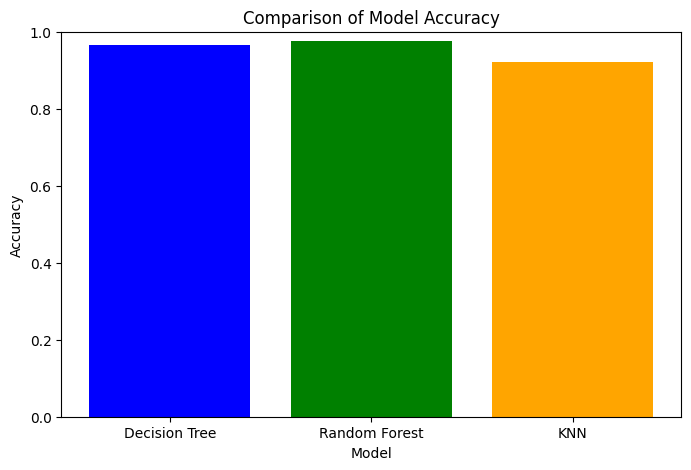

In [28]:
#metrics
results = {
    "Model": ["Decision Tree", "Random Forest", "KNN"],
    "Accuracy": [
        accuracy_score(y_test, dt_predictions),
        accuracy_score(y_test, rf_predictions),
        accuracy_score(y_test, knn_predictions)
    ]
}

#dataframe to copmrae
results_df = pd.DataFrame(results)
print(results_df)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['Accuracy'], color=['blue', 'green', 'orange', 'purple'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy")
plt.ylim(0, 1)
plt.show()

In [21]:
import joblib

In [22]:
#save DT model
joblib.dump(dt_model, 'decision_tree_model.pkl')

# save RF model
joblib.dump(rf_model, 'random_forest_model.pkl')

#save KNN model
joblib.dump(knn_model, 'knn_model.pkl')

print("All models saved")

All models saved


In [25]:
#load models
loaded_dt_model = joblib.load('decision_tree_model.pkl')
loaded_rf_model = joblib.load('random_forest_model.pkl')
loaded_knn_model = joblib.load('knn_model.pkl')

print("All models loaded")

All models loaded


In [ ]:
#predict with loaded models
dt_loaded_predictions = loaded_dt_model.predict(X_test)
rf_loaded_predictions = loaded_rf_model.predict(X_test)
knn_loaded_predictions = loaded_knn_model.predict(X_test)

#check accuracy to confirm models loaded correctly
print("Loaded Decision Tree Accuracy:", accuracy_score(y_test, dt_loaded_predictions))
print("Loaded Random Forest Accuracy:", accuracy_score(y_test, rf_loaded_predictions))
print("Loaded KNN Accuracy:", accuracy_score(y_test, knn_loaded_predictions))

In [29]:
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']